In [41]:
import numpy as np
import yfinance as yf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import random

import arch.bootstrap as ab

In [42]:
START = "2021-01-01"
END = "2025-01-01"
TICKER = "^GSPC"
TITLE = TICKER + " - " +(datetime.now()).strftime("%Y-%m-%d - %H:%M:%S")

In [43]:
data = pd.read_csv("data.csv",index_col=0)

# data = yf.download("AAPL",start=START, end=END,multi_level_index=False)

data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))

data.dropna(inplace=True)

In [44]:
def tenkan(data, t=9):
    return ((data.rolling(t).max()) + (data.rolling(t).min())) / 2

def kijin(data, t=26):
    return ((data.rolling(t).max()) + (data.rolling(t).min())) / 2

def chikou(data, t=26):
    return data.shift(-t)

def span_a(data, t_short=9, t_med=26):
    return (((tenkan(data, t_short) + kijin(data, t_med))) / 2).shift(t_med)

def span_b(data, t_med=26, t_long=52):
    return (((data.rolling(t_long).max()) + (data.rolling(t_long).min())) / 2).shift(t_med)

In [ ]:
def apply_ichi(data, short=9, medium=26, long=52, column="Adj Close"):
    data = data.copy()
    data["tenkan"] = tenkan(data[column], short)
    data["kijin"] = kijin(data[column], medium)
    data["chikou"] = chikou(data[column], medium)
    data["span_a"] = span_a(data[column], short, medium)
    data["span_b"] = span_b(data[column], medium, long)

    return data

In [57]:
ichi_data = apply_ichi(data)

# Signals

In [ ]:
# Bullish patterns

def l_1(data, t_short=9 ,t_mid=26):
    return tenkan(data, t_short) > kijin(data, t_mid)

def l_2(data, t_mid=26):
    return chikou(data, t_mid) > data.shift(t_mid)

def l_3(data,t_short=9,t_med=26):
    # Check span a and span b offsets
    return data > np.max([span_a(data,t_short,t_med), span_b(data,t_short,t_med)],axis=0)

# Bearish patterns

def s_1(data,t_short=9,t_med=26):
    return tenkan(data, t_short) < kijin(data, t_med)

def s_2(data, t_med=26):
    return chikou(data, t_med) > data.shift(t_med)

def s_3(data, t_short=9, t_med=26):
    # Check span a and span b offsets
    return data < np.min([span_a(data,t_short,t_med), span_b(data,t_short,t_med)],axis=0)


In [ ]:
l_3(data["Adj Close"]).value_counts() # Example of l_3

Adj Close
True     340
False    161
Name: count, dtype: int64

# Entry

In [ ]:
def en_l_1(data,t_short=9,t_mid=26):
    return l_1(data,t_short,t_mid) & (data > kijin(data,t_mid))

def en_l_2(data,t_mid=26):
    return l_2(data,t_mid) & (data > kijin(data,t_mid))

def en_l_12(data,):
    return l_1(data,t_short,t_mid) & l_2(data,t_mid) & (data > kijin(data,t_mid))

True     333
False    168
Name: count, dtype: int64

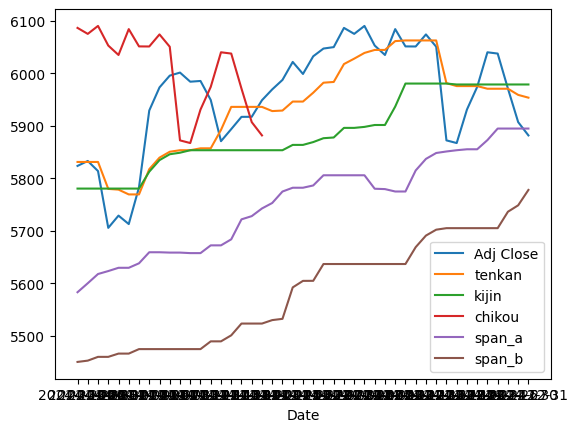

In [130]:
ax = sns.lineplot(ichi_data[-45:].drop(columns=["Volume", "Close", "Open", "High", "Low","log_return"]),dashes=False)

# for index, value in entry_l_12(ichi_data).dropna().items():
    # if value:
        # ax.axvline(index,alpha=0.1,color="green")

# for index, value in entry_s_1(ichi_data).dropna().items():
    # if value:
        # ax.axvline(index,alpha=0.1,color="red")